# 7-Channel DTF Analysis: Frequency Selectivity Demonstration

**SYNCCIN 2025 Summer School**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jzygierewicz/SYNCCIN_2025_summer_school/blob/main/7_channels_bivariate_multivariate_MVAR.ipynb)

---

**Learning Objectives**

This notebook demonstrates the **frequency selectivity** of the Directed Transfer Function (DTF) using a 7-channel EEG simulation:

1. **Understand frequency-specific connectivity**: Learn how DTF reveals different connectivity patterns across frequency bands
2. **Distinguish signal vs. noise transmission**: Identify alpha rhythm transmission vs. noise propagation


---

## **Setup: Install Dependencies & Download Data**

This cell installs all required packages and downloads the necessary data files from GitHub.

In [ ]:
# Install required packages
!pip install networkx joblib xmltodict neurokit2 -q

print("All packages installed successfully!")

## **Download Required Files**

Download all necessary data files and Python modules from the GitHub repository.

In [ ]:
import urllib.request
import os

# Base URL for the GitHub repository
base_url = "https://raw.githubusercontent.com/jzygierewicz/SYNCCIN_2025_summer_school/main/"

# Files to download
files_to_download = [
    "simulated_7_channels.joblib",  # 7-channel simulation data
    "mtmvar.py",
    "utils.py",
    "7chan_sim.png"  # Connectivity diagram
]

print("Downloading files from GitHub repository...")

for file in files_to_download:
    if not os.path.exists(file):
        try:
            urllib.request.urlretrieve(base_url + file, file)
            print(f"Downloaded: {file}")
        except Exception as e:
            print(f"Error downloading {file}: {e}")
    else:
        print(f"Already exists: {file}")

print("\nAll files ready for analysis!")

## **Import Libraries and Modules**

Import all necessary libraries including our custom MVAR analysis functions.

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import joblib
import networkx as nx
import importlib

# Local application/library imports
import mtmvar
importlib.reload(mtmvar)  # Reload to get the fixed ffDTF function
from mtmvar import (
    mvar_criterion, AR_coeff, mvar_H,
    multivariate_spectra, DTF_multivariate, ffDTF, dDTF, GPDC,
    mvar_plot, graph_plot
)
from utils import describe_dict

print("All libraries imported successfully!")

All libraries imported successfully!


# **7-Channel Simulation: Frequency-Selective Connectivity**
### **Frequency Selectivity in DTF**

The **Directed Transfer Function (DTF)** is inherently **frequency-selective**, meaning it can reveal different connectivity patterns at different frequencies:
$$
DTF_{i \rightarrow j}(f) = |H_{ji}(f)|^2
$$

Where:
- **$H_{ji}(f)$**: Transfer function from channel $i$ to channel $j$ at frequency $f$
- **Frequency-specific**: Each frequency $f$ has its own connectivity pattern

---

## **Load and Explore 7-Channel Simulation**

In [3]:
data = joblib.load('simulated_7_channels.joblib')
print('7-Channel Simulation Data Contents:')
describe_dict(data)

sim1 = data['EEG']
Fs = data['Fs'].item()  # Extract sampling frequency
N_chan, N_samp = sim1.shape
sim_chan_names = ['0', '1', '2', '3', '4', '5', '6']  # Channel names

print(f"\nSimulation Parameters:")
print(f"   Channels: {N_chan}")
print(f"   Samples: {N_samp}")
print(f"   Sampling rate: {Fs} Hz")
print(f"   Channel names: {sim_chan_names}")

7-Channel Simulation Data Contents:
EEG: ndarray, shape=(7, 2000), dtype=float64
Fs: ndarray, shape=(1, 1), dtype=uint8
channels: dict, keys=['O', '1', '2', '3', '4', '5', '6']

Simulation Parameters:
   Channels: 7
   Samples: 2000
   Sampling rate: 128 Hz
   Channel names: ['0', '1', '2', '3', '4', '5', '6']


## **Connectivity Structure Visualization**

The 7-channel simulation follows this connectivity scheme:
<img src="https://raw.githubusercontent.com/jzygierewicz/SYNCCIN_2025_summer_school/main/7chan_sim.png" alt="7-Channel Simulation Structure" width="50%"/>

- **Signal transmission**: Alpha rhythm (8-12 Hz) from Channel 0
- **Noise transmission**: Broadband noise added between other channels

## **Visualize Delay Structure**

Plot the first 20 samples to observe the **marker propagation** and **delay pattern** across channels.

In [ ]:
idx = np.arange(0, 20, 1)
Min = np.min(sim1[:, idx])
Max = np.max(sim1[:, idx])

# Create figure with N_chan subplots
fig, ax = plt.subplots(N_chan, 1, sharex=True, figsize=(10, 7))
fig.suptitle('7-Channel Simulation: Delay Structure and Marker Propagation',
             fontsize=12, fontweight='bold')

for i in range(N_chan):
    ax[i].stem(idx, sim1[i, idx], basefmt=" ")
    ax[i].set_ylabel(f'Ch {i}', fontweight='bold')
    ax[i].set_ylim([Min, Max])
    ax[i].grid(True, alpha=0.3)

    # Highlight the marker region (around sample 8)
    ax[i].axvspan(7.5, 10.5, alpha=0.2, color='red', label='Marker Region' if i == 0 else "")

ax[N_chan-1].set_xlabel('Time [samples]', fontweight='bold')
ax[0].legend()
plt.tight_layout()
plt.show()

print("Key Observations:")
print("   Notice the marker (red region) at sample ~8 in Channel 0")
print("   Observe how the marker appears delayed in other channels")

# **Multivariate MVAR Analysis**

Set up parameters for the multivariate DTF analysis with focus on frequency selectivity.

In [39]:
max_p = 15  # Maximum model order for testing
p_opt = None  # Fixed optimal model order for demonstration
crit_type = 'AIC'  # Information criterion
f = np.arange(0, 30, 0.1)  # Frequency vector (focus on 0-30 Hz range)
N_f = f.shape[0]

Compute the **auto-spectra** and **cross-spectra** using the multivariate approach with fixed model order.

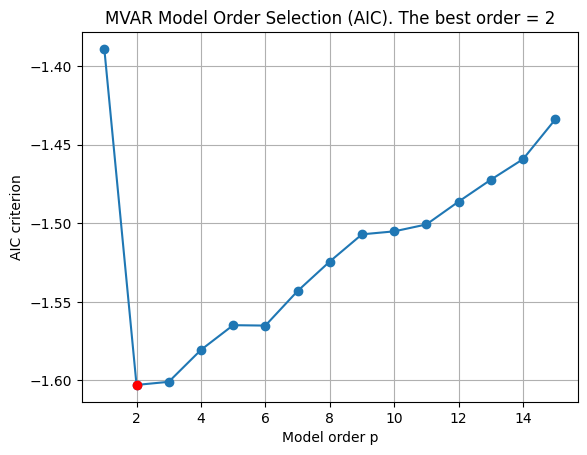

Optimal model order for all channels: p =  2


In [40]:
S_multivariate = multivariate_spectra(sim1, f, Fs, max_p, p_opt=p_opt, crit_type=crit_type)

Calculate the **Directed Transfer Function**.

In [41]:
DTF = DTF_multivariate(sim1, f, Fs, max_p=20, p_opt=p_opt, crit_type=crit_type)

Optimal model order for all channels: p =  2


# DTF Results: Frequency-Selective Analysis

## Matrix Visualization: Full Frequency Range

Display the DTF matrix showing connectivity patterns across all frequencies.

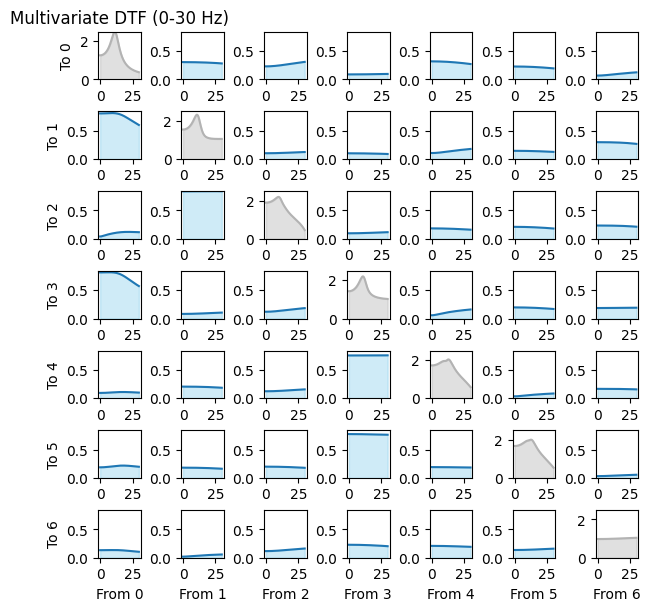


Analysis Points:
   Look at the first column (From Channel 0) - should show strong alpha connectivity
   Alpha peak (~10 Hz) should be prominent in Channel 0 → Others
   Other connections 1 → 2 , and 3 → 4, 3 → 5 show broadband or noise-like patterns
   Compare alpha-specific vs. broadband transmission patterns


In [ ]:
mvar_plot(S_multivariate, DTF, f, 'From ', 'To ', sim_chan_names,
          'Multivariate DTF (0-30 Hz)', 'sqrt')
plt.show() 

print("\nAnalysis Points:")
print("   Look at the first column (From Channel 0) - should show strong alpha connectivity")
print("   Alpha peak (~10 Hz) should be prominent in Channel 0 → Others")
print("   Other connections 1 → 2 , and 3 → 4, 3 → 5 show broadband or noise-like patterns")
print("   Compare alpha-specific vs. broadband transmission patterns")

# Network Analysis: Frequency Band Comparison

## Alpha Band vs. Broadband Connectivity

Compare connectivity patterns between the **alpha band (8-12 Hz)** and **full frequency range (0-30 Hz)**.

Alpha Band Analysis (8-12 Hz):
Broadband Analysis (0-30 Hz):


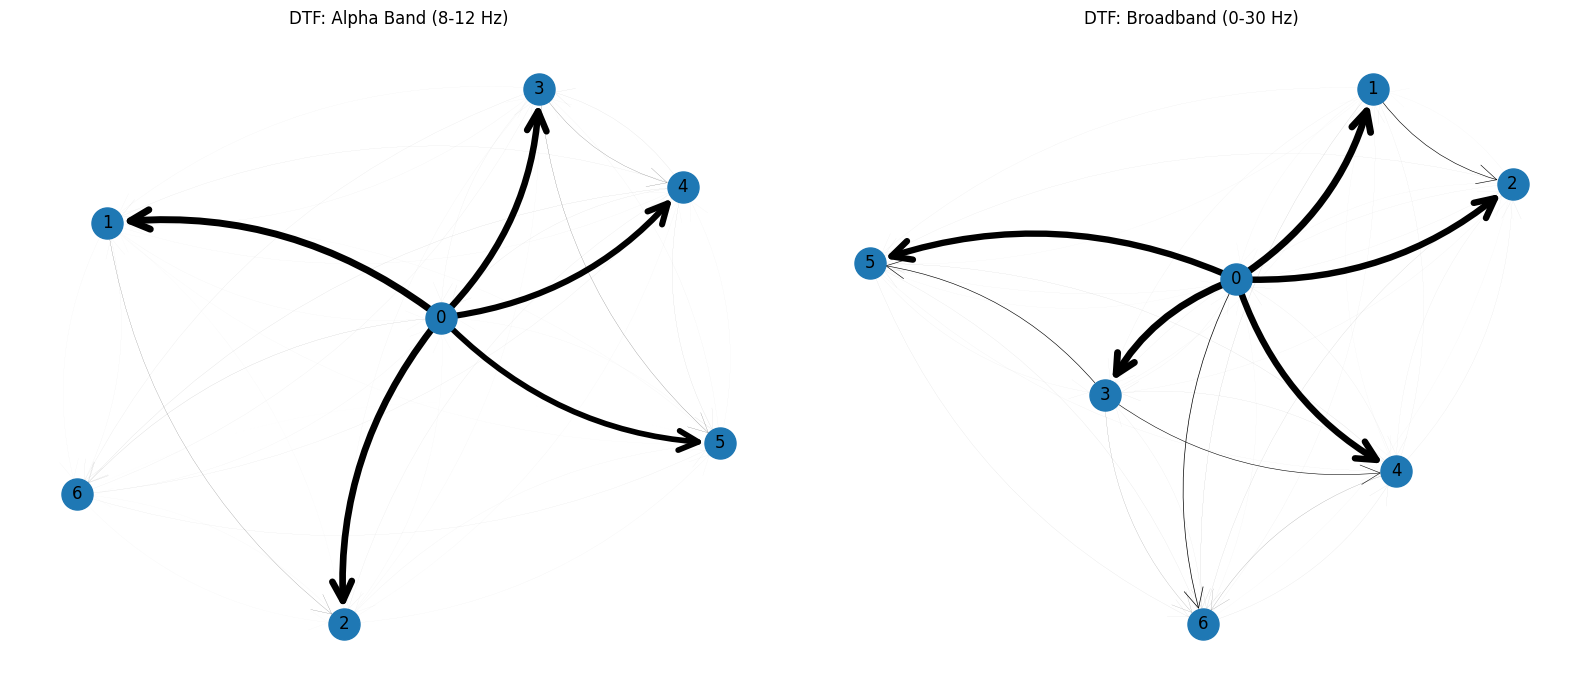

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 7))

# Alpha band analysis (8-12 Hz)
f_range_alpha = (8, 12)
print(f"Alpha Band Analysis ({f_range_alpha[0]}-{f_range_alpha[1]} Hz):")
G_alpha = graph_plot(DTF, axs[0], f, f_range_alpha, sim_chan_names,
                     f'DTF: Alpha Band ({f_range_alpha[0]}-{f_range_alpha[1]} Hz)')

# Broadband analysis (0-30 Hz)
f_range_broad = (0, 30)
print(f"Broadband Analysis ({f_range_broad[0]}-{f_range_broad[1]} Hz):")
G_all = graph_plot(DTF, axs[1], f, f_range_broad, sim_chan_names,
                   f'DTF: Broadband ({f_range_broad[0]}-{f_range_broad[1]} Hz)')

plt.tight_layout()
plt.show()

# Observations

- We can observe that channel 0 is the source of alpha rhythm passing information to channels 1, 2, 3, 4, and 5.
- Transmission from channel 1 to 2 has flat spectral characteristic - this signifies that what is transmitted from channel 1 to 2 is only the noise we added to channel 1. The same is seen in the transmission from channel 3 to 4 and 5.
- Visualisation of the narrowband graph focussed on the alpha peak shows the propagation of alpha activity. Making the frequency band broad reveals also the transmition of noise. Both results are compatible with the simulation structure.

Thus with the multivariate DTF we can distinguish the source of alpha rhythm from the sources of noise added to channels 1, 2, 3, 4, and 5.


# **Conclusions**
DTF is frequency specific, which can be useful in real cases whne the analysed signal contains many rhythms (e.g., EEG theta, alpha, beta ), and for each of them the connectivity pattern is different.

## Suggested next steps
- Explore the impact of different model orders on DTF results.
- Investigate the effects of noise on DTF estimates.
- Experiment what the results would be in the case of bivariate analysis. Can it also reveal the correct transmition pattern separating alpha spource from noise?

- Compare DTF results with other connectivity measures (e.g., ffDTF, dDTF, gPDC - this functions are implemented in `mtmvar.py` and return connectivity matrices in the same format as DTF): 

`ff_DTF = ffDTF(sim1, f, Fs, max_p=20, p_opt=p_opt, crit_type=crit_type)`

`d_DTF = dDTF(sim1, f, Fs, max_p=20, p_opt=p_opt, crit_type=crit_type)`

`gPDC = GPDC(sim1, f, Fs, max_p=20, p_opt=p_opt, crit_type=crit_type)`


---
**Educational Materials**: [SYNCCIN 2025 Repository](https://github.com/jzygierewicz/SYNCCIN_2025_summer_school)
- **Author**: Jarosław Żygierewicz
- **Institution**: University of Warsaw
- **Event**: SYNCCIN 2025 Summer School